# **GP(Gaussian Process)를 이용한 Odor 분석**

---

https://www.youtube.com/watch?v=QvcHrwXS4_U

http://egloos.zum.com/incredible/v/7480714

## **0. Packages Installation**

In [10]:
import pandas as pd
import numpy as np
import csv

# !pip install impyute
from impyute import mice

## **1. Data Preparation**

### **1) Read and Select to variable (odo)**

In [11]:
# od = pd.read_csv("drive/MyDrive/PLS_양돈 농가/s1.csv",  encoding = "euc-kr")
# od = pd.read_csv("drive/MyDrive/PLS_양돈 농가/s2.csv",  encoding = "euc-kr")
od = pd.read_csv("drive/MyDrive/PLS_양돈 농가/s3.csv",  encoding = "euc-kr")
# od = pd.read_csv("drive/MyDrive/PLS_양돈 농가/s4.csv",  encoding = "euc-kr")
od.head()

,측정일,농장명,complex odor,Ammoina,Hydorgen sulfide,Methyl mercaptan,Dimethyl sulfide,Dimethyl disulfide,Acetic acid,Propionic acid,iso-Butryic aicd,Butricy aicd,iso-Valeric acid,Valeric acid,Phenol,p-Cresol,Indole,Skatole
0,18.04.24,양지,1000.0,0.11,190.0,17.30,364.00,0.05,783.66,810.05,85.98,811.38,255.58,526.00,25.22,109.27,7.41,7.95
1,18.05.01,양지,310.0,0.82,128.0,11.60,6.55,0.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18.05.01,양지,NaN,NaN,NaN,NaN,NaN,NaN,30.60,17.57,2.78,10.80,3.64,7.72,2.84,0.06,0.05,3.00
3,18.05.08,양지,300.0,1.10,350.0,0.07,0.07,0.02,444.78,496.03,43.95,726.10,151.78,228.74,8.11,60.50,0.41,3.11
4,18.05.08,양지,300.0,1.35,136.0,0.07,40.90,0.02,663.42,737.23,73.94,837.83,215.64,469.79,14.61,67.52,0.94,3.92


In [12]:
odo = od.drop(["측정일", "농장명"], axis = 1)
odo.head()

,complex odor,Ammoina,Hydorgen sulfide,Methyl mercaptan,Dimethyl sulfide,Dimethyl disulfide,Acetic acid,Propionic acid,iso-Butryic aicd,Butricy aicd,iso-Valeric acid,Valeric acid,Phenol,p-Cresol,Indole,Skatole
0,1000.0,0.11,190.0,17.30,364.00,0.05,783.66,810.05,85.98,811.38,255.58,526.00,25.22,109.27,7.41,7.95
1,310.0,0.82,128.0,11.60,6.55,0.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,30.60,17.57,2.78,10.80,3.64,7.72,2.84,0.06,0.05,3.00
3,300.0,1.10,350.0,0.07,0.07,0.02,444.78,496.03,43.95,726.10,151.78,228.74,8.11,60.50,0.41,3.11
4,300.0,1.35,136.0,0.07,40.90,0.02,663.42,737.23,73.94,837.83,215.64,469.79,14.61,67.52,0.94,3.92


### **2) 결측치 확인 및 처리**

#### - 결측치 확인

In [13]:
### 결측값 개수
print(odo.isnull().sum())

complex odor          1
Ammoina               1
Hydorgen sulfide      1
Methyl mercaptan      1
Dimethyl sulfide      1
Dimethyl disulfide    1
Acetic acid           1
Propionic acid        1
iso-Butryic aicd      1
Butricy aicd          1
iso-Valeric acid      1
Valeric acid          1
Phenol                1
p-Cresol              1
Indole                1
Skatole               1
dtype: int64


In [14]:
### ND 개수
print(odo.isin(['ND']).sum())

complex odor          0
Ammoina               0
Hydorgen sulfide      0
Methyl mercaptan      0
Dimethyl sulfide      0
Dimethyl disulfide    0
Acetic acid           0
Propionic acid        0
iso-Butryic aicd      0
Butricy aicd          0
iso-Valeric acid      0
Valeric acid          0
Phenol                3
p-Cresol              0
Indole                7
Skatole               0
dtype: int64


In [15]:
na = odo.isnull().sum().sum()
nd = odo.isin(['ND']).sum().sum()

#### - 결측치 처리 (ND->0, NA->M.I)


In [16]:
### ND -> 0
odo = odo.replace("ND", 0)

In [17]:
### NA -> mice
### mice를 위해 모든 Type을 float로 변경
odo.info()
odo = odo.astype("float")
odo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   complex odor        28 non-null     float64
 1   Ammoina             28 non-null     float64
 2   Hydorgen sulfide    28 non-null     float64
 3   Methyl mercaptan    28 non-null     float64
 4   Dimethyl sulfide    28 non-null     float64
 5   Dimethyl disulfide  28 non-null     float64
 6   Acetic acid         28 non-null     float64
 7   Propionic acid      28 non-null     float64
 8   iso-Butryic aicd    28 non-null     float64
 9   Butricy aicd        28 non-null     float64
 10  iso-Valeric acid    28 non-null     float64
 11  Valeric acid        28 non-null     float64
 12  Phenol              28 non-null     object 
 13  p-Cresol            28 non-null     float64
 14  Indole              28 non-null     object 
 15  Skatole             28 non-null     float64
dtypes: float64

In [18]:
name = list(odo.columns)
odo = pd.DataFrame(np.round(mice(odo.values).astype(float), 2))
odo.columns = name
odo.head()

,complex odor,Ammoina,Hydorgen sulfide,Methyl mercaptan,Dimethyl sulfide,Dimethyl disulfide,Acetic acid,Propionic acid,iso-Butryic aicd,Butricy aicd,iso-Valeric acid,Valeric acid,Phenol,p-Cresol,Indole,Skatole
0,1000.00,0.11,190.00,17.30,364.00,0.05,783.66,810.05,85.98,811.38,255.58,526.00,25.22,109.27,7.41,7.95
1,310.00,0.82,128.00,11.60,6.55,0.16,189.67,596.78,25.04,-145.56,75.25,600.77,28.43,60.94,1.67,-2.56
2,594.62,2.48,-341.51,12.72,-8.01,0.04,30.60,17.57,2.78,10.80,3.64,7.72,2.84,0.06,0.05,3.00
3,300.00,1.10,350.00,0.07,0.07,0.02,444.78,496.03,43.95,726.10,151.78,228.74,8.11,60.50,0.41,3.11
4,300.00,1.35,136.00,0.07,40.90,0.02,663.42,737.23,73.94,837.83,215.64,469.79,14.61,67.52,0.94,3.92


In [19]:
print("결측치 개수 :", na, "개 ->", odo.isnull().sum().sum(), "개")

print("ND 개수 : ", nd, "개 ->", odo.isin(['ND']).sum().sum())

결측치 개수 : 16 개 -> 0 개
ND 개수 :  10 개 -> 0


## **2. Gaussian Process**
---

In [20]:
y = odo["complex odor"]
X = odo.drop("complex odor", axis = 1)
X.head()

,Ammoina,Hydorgen sulfide,Methyl mercaptan,Dimethyl sulfide,Dimethyl disulfide,Acetic acid,Propionic acid,iso-Butryic aicd,Butricy aicd,iso-Valeric acid,Valeric acid,Phenol,p-Cresol,Indole,Skatole
0,0.11,190.00,17.30,364.00,0.05,783.66,810.05,85.98,811.38,255.58,526.00,25.22,109.27,7.41,7.95
1,0.82,128.00,11.60,6.55,0.16,189.67,596.78,25.04,-145.56,75.25,600.77,28.43,60.94,1.67,-2.56
2,2.48,-341.51,12.72,-8.01,0.04,30.60,17.57,2.78,10.80,3.64,7.72,2.84,0.06,0.05,3.00
3,1.10,350.00,0.07,0.07,0.02,444.78,496.03,43.95,726.10,151.78,228.74,8.11,60.50,0.41,3.11
4,1.35,136.00,0.07,40.90,0.02,663.42,737.23,73.94,837.83,215.64,469.79,14.61,67.52,0.94,3.92


In [21]:
# !pip install sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel,  RationalQuadratic as RQ, ExpSineSquared as Exp, DotProduct as Lin

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

gp = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer = 1)

# gp.fit(train_X, train_y)

In [28]:
preds = []
sigmas = []

for i in range(X.shape[0]) :
  
  # Training set and Test set
  train_X = X.drop(i, axis = 0)
  train_y = y.drop(i)
  test_X = X.loc[i, ]
  test_y = y.loc[i]

  # Model fit
  gp.fit(train_X, train_y)

  # Prediction
  Q = np.atleast_2d(test_X)
  y_pred, sigma = gp.predict(Q, return_std = True)
  preds.append(y_pred)
  sigmas.append(sigma)


In [29]:
e = [y[i]-preds[i] for i in range(len(y))]
e2 = [e[i]**2 for i in range(len(e))]
np.round(sum(e2)/len(e2),2)

array([991630.46])

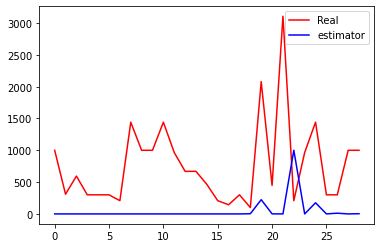

In [30]:
import matplotlib.pyplot as plt

plt.plot(y, color = "red", label = "Real")
plt.plot(preds, color = "blue", label = "estimator")
plt.legend(loc = "upper right")
plt.show()